In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# from surprise import evaluate 
from surprise.model_selection.validation import cross_validate

sns.set_style("darkgrid")

# ИИ, препоръчай ми филм!

### Как работят основните алгоритми за препоръчване чрез машинно самооубучение



## Резюме

<b> Алгоритмите за машинно самообучение, свързани с препоръчване, </b> са едни от най-използваните прилложения, още от зараждането на това направление. 

Разработката тук е свързана с [журналистически материал, който предстои да бъде публикуван](https://docs.google.com/document/d/134zZr_pZLMu49uEu0ppKht0ytunXujS5IIcL5bi5kiU/edit?usp=sharing) на сайта „Дигитални истории“, разказваща накратко за основните направления в областта на алгоритмите за препоръчване.

Основните подходи са два: колаборативно филтриране и филтриране, базирано на съдържанието. В по-модерните решения се използва своеобразна комбинация,така че да се използват силните страни и на двата подхода. 

Колаборация, или сътрудничество, ще рече, че хората работят заедно, за да постигнат даден резултат. Това стои в основата на колаборативното филтриране. Същият принцип, който споменахме и продължаваме да използваме и днес. А на езика на продажбите: „Хората, които купиха…, купиха и…“. Целта на алгоритмите в този случай е да обработи данните така, че максимално да потърси общите черти в избора на различните потребители, така че да изведе общите точки.

Като цяло подходът е следният. Алгоритъмът събира хората, които са давали максимално близки рейтинги, както потребителя, на когото ще препоръчваме. После данните се използват, за да се изчисли колко е вероятно хората със сходен вкус да харесат и друг продукт от същата група. Измежду хората, харесали любимите ви филми, да намерим средните показатели за следващия филм и да видим кои са най-високи. Като, разбира се, опитаме да игнорираме например филмите, които имат твърде малко оценки, потребителите, които дават твърде разнопосочни числа. Или, т.нар. „пристрастие“, което в света на технологиите общо взето всички наричат с английския термин “bias”.

Филтрирането, базирано на съдържание, обръща наобратно перспективата, базирайки се на отделните единици, нека в случая използваме филми. Сравняват се оценките на потребителите за всяка двойка филми и на базата на това се определя какъв би бил рейтингът на този, който още не е гледал втория филм.

Една от компаниите пионери в тази област и същевременно доказано най-успешна в нея, е „Нетфликс“. Именно това, което се знае за техните алгоритми ще разгледаме в настоящия проект.

### Въвеждане на данните

Използвани са данните от официалните състезания за прреопърачващи алгоритми, организирани от „Нетфликс“. Днес те са достъпни в платформата [Kaggle](https://www.kaggle.com/netflix-inc/netflix-prize-data). Четири файла с данни събират потребителските рейтинги на филми, допълнителен файл съдържа данни за името на филмите и уникалния номер, с който се асоциират. Цялата колекция от данни съдържа 100 милиона рейтинги на 480 000 зрители за 17 000 филма.

Тъй като данните са огромни (Всеки от 4-те основно файла е по около 500 мегабайта), за демонстративни цели се използва само първият.

Първата задача е данните да бъдат прочетени и подредени в таблица с уникалните номера на зрителите, филмите, рейтингите и датите. Също от съображение за бързина данните са лимитирани до първите 300 000 записа.


In [5]:
def readFile(file_path, rows):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    f = open(file_path, "r")
    count = 0
    for line in f:
        count += 1
        if count > rows:
            break
            
        if ':' in line:
            movidId = line[:-2] # remove the last character ':'
            movieId = int(movidId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    f.close()
            
    return pd.DataFrame(data_dict)

In [6]:
df = readFile('combined_data.txt', rows=300000)

### Запознаване с данните

In [7]:
df.head()

,Cust_Id,Movie_Id,Rating,Date
0,2532865,4500,4,2005-07-26
1,573364,4500,3,2005-06-20
2,1696725,4500,3,2004-02-27
3,1253431,4500,3,2004-03-31
4,1265574,4500,2,2003-09-01


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Movie_Id,299922.0,4538.958956,22.276494,4500.0,4520.0,4545.0,4552.0,4577.0


In [9]:
df['Rating'] = df['Rating'].astype(float)

In [10]:
df.index = np.arange(0,len(df))
df.shape

(299922, 4)

In [11]:
grouped_by_movies = df.groupby('Movie_Id').agg(['count'])
movie_count = grouped_by_movies.shape[0]
grouped_by_movies.head()

,Cust_Id,Rating,Date
,count,count,count
Movie_Id,,,
4500,258,258,258
4501,595,595,595
4502,104,104,104
4503,1779,1779,1779
4504,176,176,176


In [12]:
df['Movie_Id'].value_counts().head()

4545    70799
4506    33731
4520    26500
4546    23270
4570    20703
Name: Movie_Id, dtype: int64

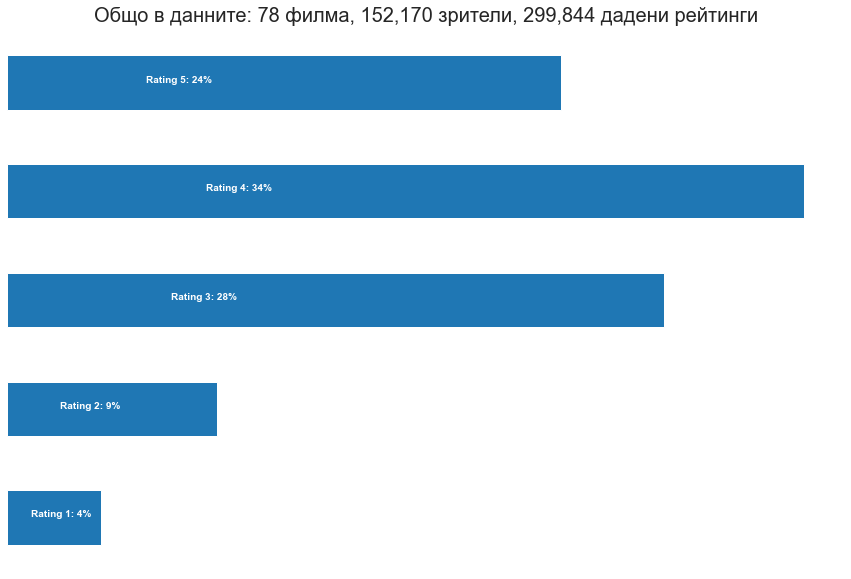

In [13]:
ratings = df.groupby('Rating')['Rating'].agg(['count'])

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = ratings.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Общо в данните: {:,} филма, {:,} зрители, {:,} дадени рейтинги'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(ratings.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, ratings.iloc[i-1][0]*100 / ratings.sum()[0]), color = 'white', weight = 'bold')

### Първоначални изводи

- В данните имаме 78 филма, над 150 хиляди зрители и почти 300 000 рейтинга.
- Рейтингите са достатъчно разнообразни и стратифицирани, за да позволяват обработка.
- Някои от филмите имат много голям брой рейтинги (над 20 000), което позволява да се направи обработка на данните с цел търсене на препоръки.

In [14]:
names = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(names)
df_movie_summary.head()

,count,mean
Movie_Id,,
4500,258,3.329457
4501,595,3.043697
4502,104,2.144231
4503,1779,3.213603
4504,176,3.153409


In [15]:
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Минимален брой ревюта на филм: {}'.format(movie_benchmark))

Минимален брой ревюта на филм: 2239.0


In [16]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(names)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Минимален брой ревюта на потребител: {}'.format(cust_benchmark))

Минимален брой ревюта на потребител: 2.0


### Допълнителни изводи

- Всеки от филмите има достатъчно сериозен брой ревюта (поне 2200)
- Всеки потребител има поне 2 ревюта. 
- Следва да продължим със съпоставянето на данните от уникалните номера на филмите с конкретните заглавия

In [17]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.head(10)

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
6,7,1992.0,8 Man
7,8,2004.0,What the #$*! Do We Know!?
8,9,1991.0,Class of Nuke 'Em High 2
9,10,2001.0,Fighter


### Създаване на модел и трениране с данните

Време е за същинската работа на алгоритъма. Използваме крос-валидация с разделяне на данните в 5 групи.
За отчитане на грешките се използва мерките RMSE и MAE. 

In [18]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9977  1.0058  1.0059  1.0056  1.0031  1.0036  0.0031  
MAE (testset)     0.7853  0.7938  0.7924  0.7928  0.7917  0.7912  0.0030  
Fit time          14.01   13.82   17.29   24.50   17.18   17.36   3.87    
Test time         0.53    0.51    0.46    0.65    0.61    0.55    0.07    


{'test_rmse': array([0.99772763, 1.00576907, 1.00591249, 1.00557572, 1.00305503]),
 'test_mae': array([0.78534419, 0.79383643, 0.79238236, 0.79277016, 0.79174103]),
 'fit_time': (14.012413501739502,
  13.823903322219849,
  17.294578552246094,
  24.498799562454224,
  17.17684578895569),
 'test_time': (0.5266149044036865,
  0.5126292705535889,
  0.46276187896728516,
  0.6513533592224121,
  0.6137173175811768)}

### Въвеждане на пълните данни

Моделът дава доста добри показатели. След като той вече е трениран, е време да го обучим с целия обем данни.

In [19]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Моделът вече е готов за даване на препоръки. Ето кои са филмите, които е оценил с оценка над 2 даден потребител с уникален номер 573364.


In [20]:
df_573364 = df[(df['Cust_Id'] == '573364') & (df['Rating'] > 2)]
df_573364 = df_573364.set_index('Movie_Id')
df_573364 = df_573364.join(df_title)['Name']
df_573364.head(df_573364.shape[0])

Movie_Id
4500    Open Hearts
4570           Mast
4577     Red Lights
Name: Name, dtype: object

### Препоръки

А това са филмите, които би препоръчал алгоритъмът на базата на тези оценки и предпологаемите оценки, които би им поставил потребителят.

In [21]:
titles = df_title.copy()

titles['Estimate_Score'] = titles['Movie_Id'].apply(lambda x: svd.predict(573364, x).est)
titles = titles.sort_values(by=['Estimate_Score'], ascending=False)
titles.head(10)

,Movie_Id,Year,Name,Estimate_Score
4530,4531,2004.0,The Best of Triumph the Insult Comic Dog,4.111764
4508,4509,1977.0,Little House on the Prairie: Season 4,4.049593
4574,4575,1969.0,Scooby-Doo Where Are You?: Seasons 1 & 2,4.015605
4560,4561,1999.0,Everybody Loves Raymond: Season 4,3.996140
4505,4506,1961.0,Breakfast at Tiffany's,3.971410
4520,4521,2002.0,Wire in the Blood: Justice Painted Blind,3.968801
4544,4545,1990.0,Dances With Wolves: Special Edition,3.948853
4558,4559,1974.0,Hearts and Minds,3.947487
4576,4577,1989.0,Steel Magnolias,3.919479
4521,4522,1998.0,Independent's Day,3.854927


Трансформираме данните в пивот таблица, за да потърсим връзките между филми. Кои филми би препоръчал алгоритъмът ни на базата на това, че дадени зрители са оценили високо друг филм.

In [22]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_p.head()

Movie_Id,4500,4501,4502,4503,4504,4505,4506,4507,4508,4509,...,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577
Cust_Id,,,,,,,,,,,,,,,,,,,,,
100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def recommend(movie_title, min_count):
  print("За филма {}".format(movie_title))
  print("Топ 10 филмови препоръки, базирани на коефициента на Пиърсън - ")
  i = int(df_title.index[df_title['Name'] == movie_title][0])
  target = df_p[i]
  similar_to_target = df_p.corrwith(target)
  corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
  corr_target.dropna(inplace = True)
  corr_target = corr_target.sort_values('PearsonR', ascending = False)
  corr_target.index = corr_target.index.map(int)
  corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
  print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

Филми, които алгоритъмът препоръчва на харесалите „Пипи Дългото Чорапче“ на базата на коефициента на Пиърсън.

In [24]:
recommend("Pippi on the Run", 0)

За филма Pippi on the Run
Топ 10 филмови препоръки, базирани на коефициента на Пиърсън - 
 PearsonR                        Name  count      mean
      1.0            Pippi on the Run     92  2.771739
      1.0                      Bat 21    204  3.328431
      1.0                   Def Con 4    245  3.661224
      1.0           Independent's Day    962  3.965696
      1.0  The Falcon and the Snowman    164  2.609756
      1.0               Stealing Time    197  3.568528
      1.0             Steel Magnolias    122  3.704918
      1.0            The Cherokee Kid    116  3.000000
      1.0                  Jennifer 8     92  1.880435
      1.0                  Mixed Nuts    116  2.948276


## Използвани източници

- [Google Developers](https://developers.google.com/machine-learning/recommendation)
- [Machine Learning for Building Recommender System in Python](https://towardsdatascience.com/machine-learning-for-building-recommender-system-in-python-9e4922dd7e97)
- [Recommender Systems](https://www.ritchieng.com/machine-learning-recommender-systems/)
- [Recommendation-System](https://github.com/Ireneyou33/Recommendation-System)